In [17]:
# Step 1: Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score

import joblib

# Set up a consistent visual style
sns.set(style="whitegrid")

In [2]:
# Step 2: Load Dataset
# Loading the dataset into a Pandas DataFrame
data_path = "./dataset.csv"  # Update this path with the actual file location
df = pd.read_csv(data_path)

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns}")

# create visualization forlder
if not os.path.exists("visualization"):
    os.makedirs("visualization")

Dataset Shape: (300153, 12)
Columns: Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price'],
      dtype='object')


## Problem Selection

The problem of predicting flight prices is highly relevant to industries like travel and hospitality. Understanding pricing behavior helps airlines optimize revenue and assists passengers in planning cost-effective travel. It ties closely to machine learning topics like regression, feature engineering, and ensemble modeling.



Dataset Shape: (300153, 12)
Columns: Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price'],
      dtype='object')
Data Types:
Unnamed: 0            int64
airline              object
flight               object
source_city          object
departure_time       object
stops                object
arrival_time         object
destination_city     object
class                object
duration            float64
days_left             int64
price                 int64
dtype: object
Missing Values:
Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64


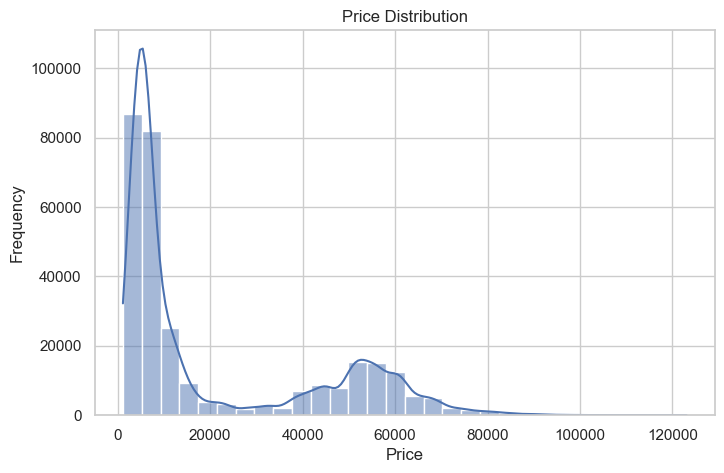

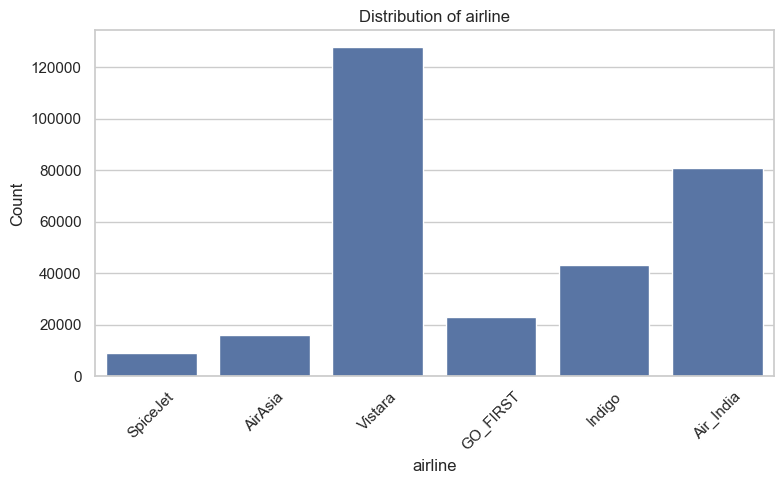

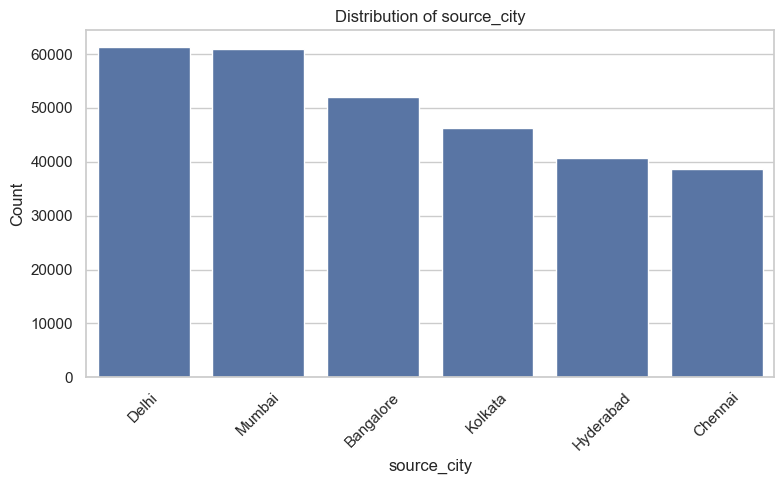

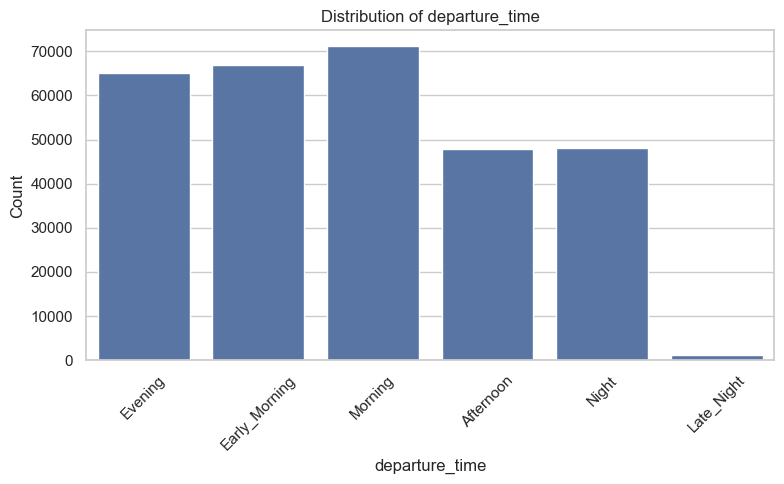

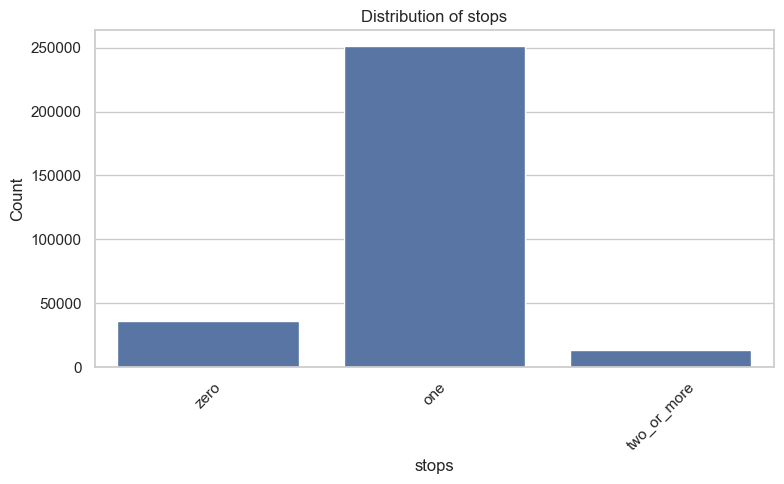

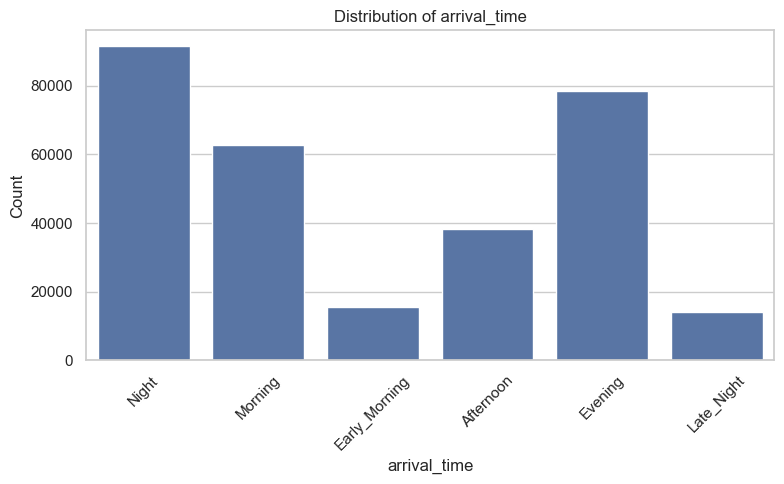

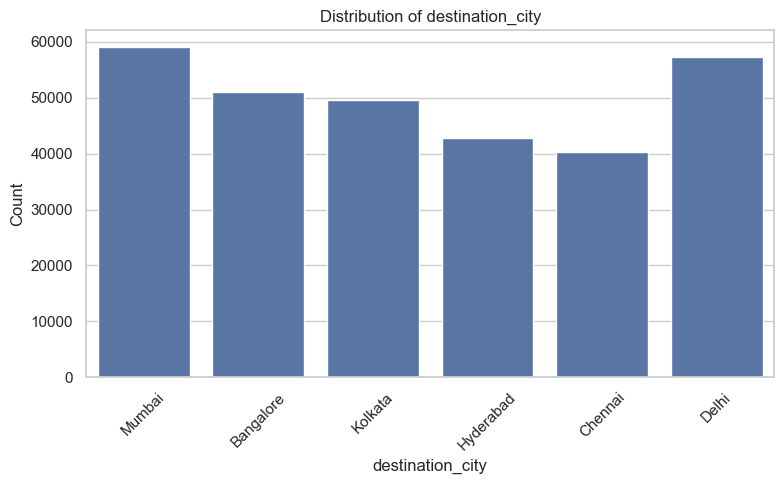

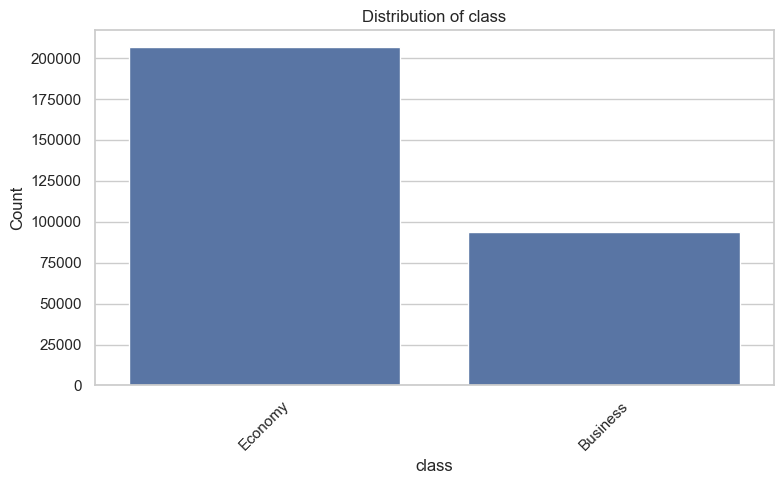

In [3]:
# Step 3: Data Exploration
# Analyze dataset shape, columns, and data types
print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns}")
print(f"Data Types:\n{df.dtypes}")

# Check for missing values
print(f"Missing Values:\n{df.isnull().sum()}")

# Summary statistics of the dataset
df.describe()

# Visualize price distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["price"], kde=True, bins=30)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Categorical feature analysis
categorical_columns = [
    "airline",
    "source_city",
    "departure_time",
    "stops",
    "arrival_time",
    "destination_city",
    "class",
]
for col in categorical_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df[col])
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"./visualization/{col}_distribution.png", dpi=100)
    plt.show()

# Data Visualization

## Plot 1: Distribution of Flight Prices

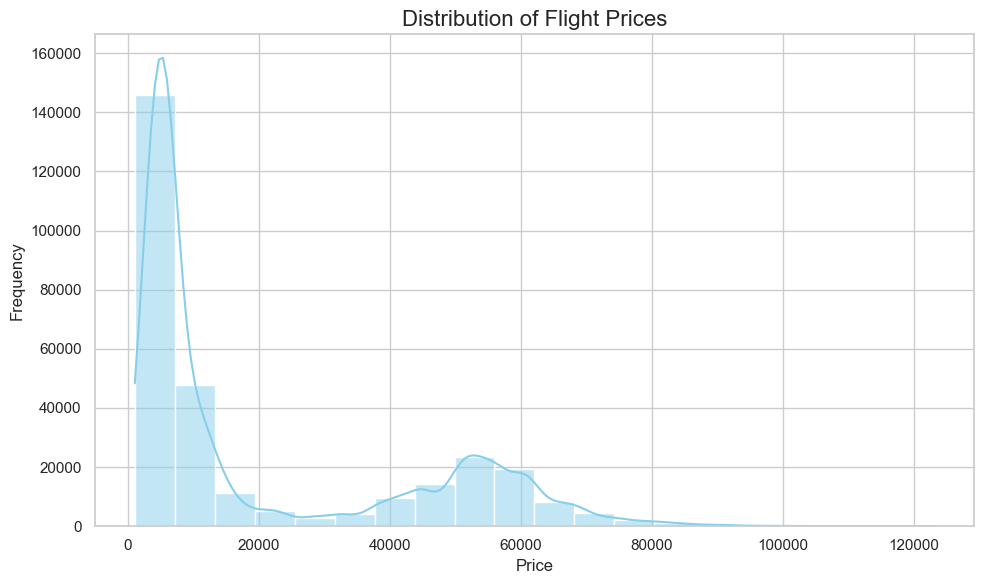

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(df["price"], kde=True, color="skyblue", bins=20)
plt.title("Distribution of Flight Prices", fontsize=16)
plt.xlabel("Price", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.savefig("./visualization/price_distribution.png", dpi=100)
plt.show()

## Plot 2: Price by Airline

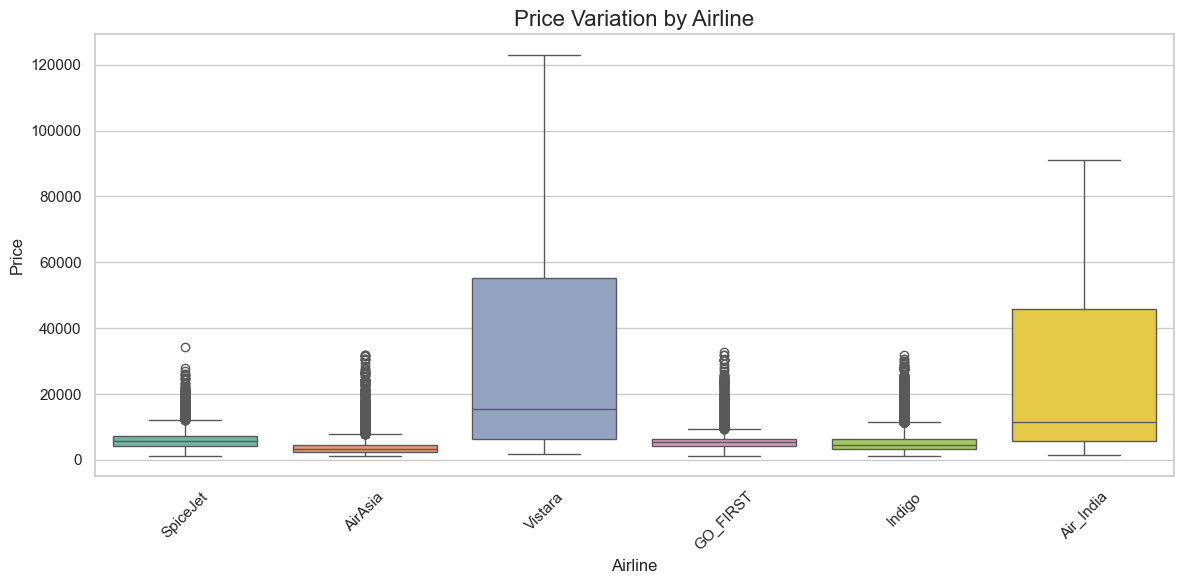

In [5]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="airline", y="price", palette="Set2", hue="airline")
plt.title("Price Variation by Airline", fontsize=16)
plt.xlabel("Airline", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./visualization/price_by_airline.png", dpi=100)
plt.show()

## Plot 3: Price vs. Departure Time

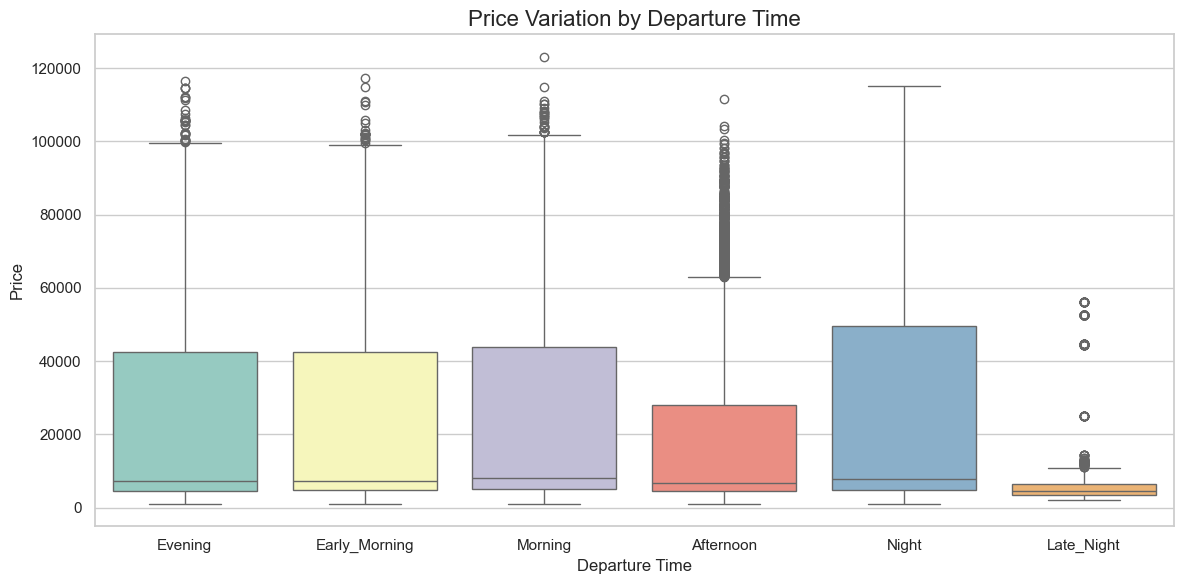

In [6]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="departure_time", y="price", hue="departure_time", palette="Set3")
plt.title("Price Variation by Departure Time", fontsize=16)
plt.xlabel("Departure Time", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.tight_layout()
plt.savefig("./visualization/price_by_departure_time.png", dpi=100)
plt.show()

## Plot 4: Price vs. Flight Class

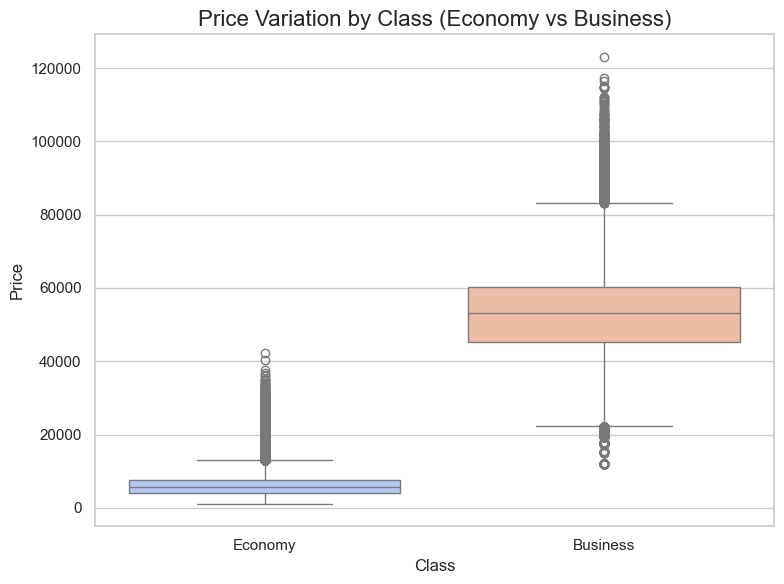

In [7]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="class", y="price", palette="coolwarm", hue="class", legend=False)
plt.title("Price Variation by Class (Economy vs Business)", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.tight_layout()
plt.savefig("./visualization/price_by_class.png", dpi=100)
plt.show()

## Plot 5: Correlation Heatmap for Numerical Variables

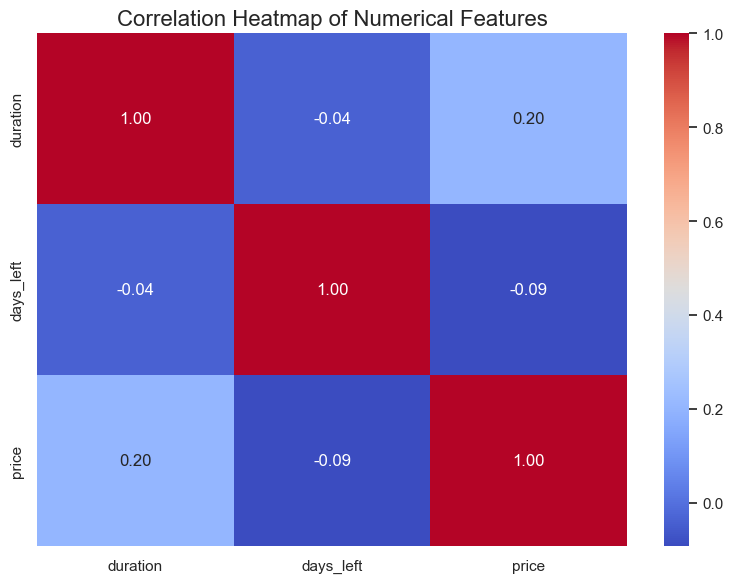

In [8]:
plt.figure(figsize=(8, 6))
correlation = df[["duration", "days_left", "price"]].corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.tight_layout()
plt.savefig("./visualization/correlation_heatmap.png", dpi=100)
plt.show()

## Plot 6: Route Analysis

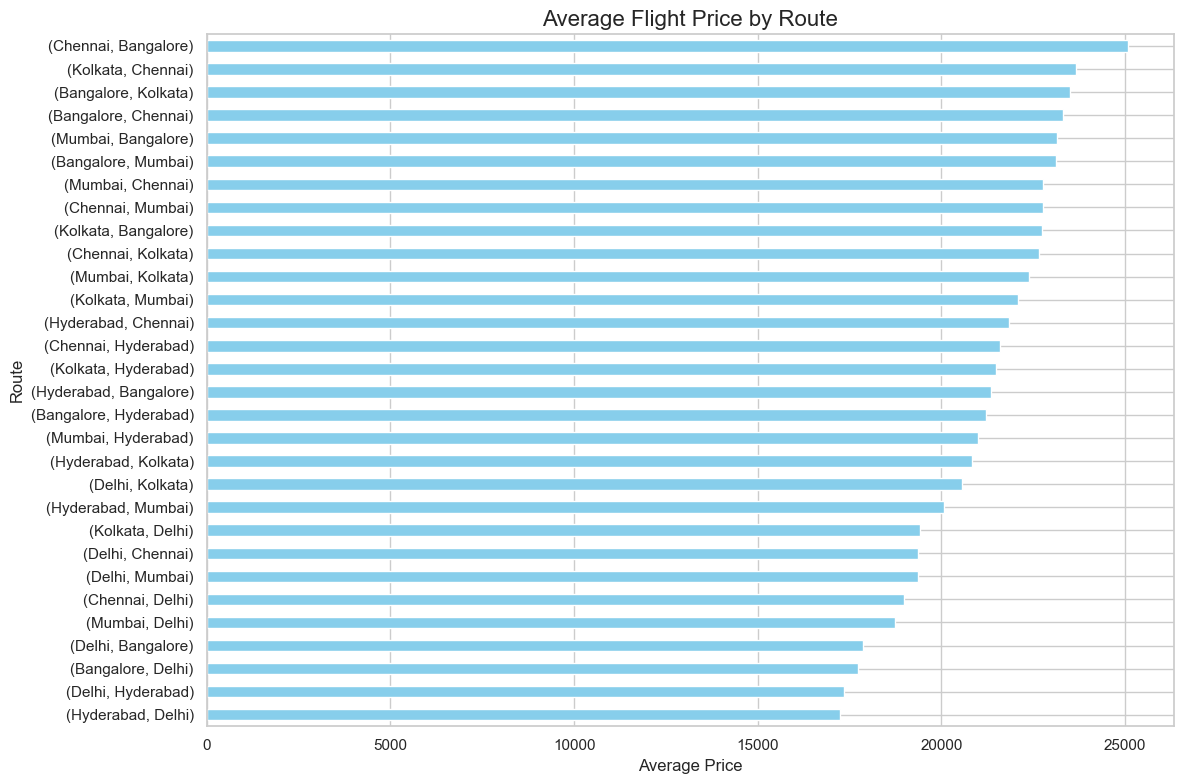

In [9]:
# Grouping by source and destination cities
route = df.groupby(["source_city", "destination_city"])["price"].mean().sort_values()

# Plotting
plt.figure(figsize=(12, 8))
route.plot(kind="barh", color="skyblue")
plt.title("Average Flight Price by Route", fontsize=16)
plt.xlabel("Average Price")
plt.ylabel("Route")
plt.tight_layout()
plt.savefig("./visualization/average_price_by_route.png", dpi=100)
plt.show()

## Plot 7: Outlier Analysis

/var/folders/z6/fz7p_t5j2zdcx0r2h3wlzzs80000gn/T/ipykernel_7828/3101202043.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y="price", palette="Set1")


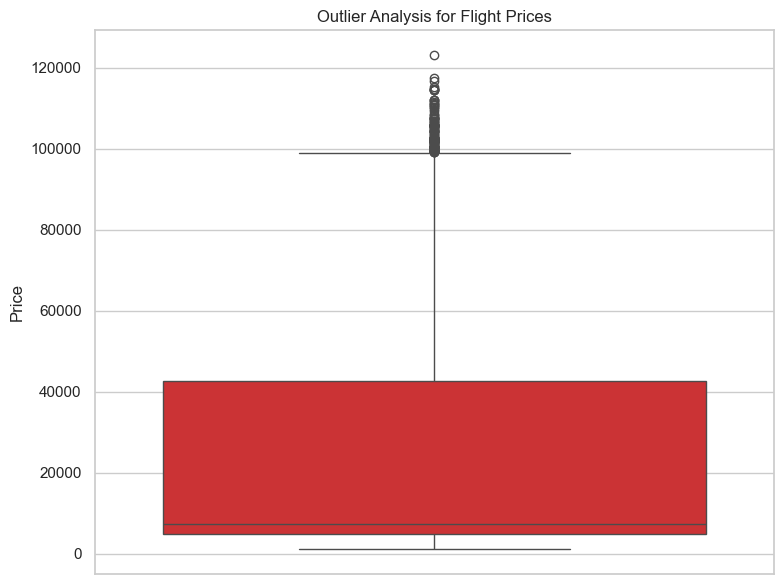

In [10]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y="price", palette="Set1")
plt.title("Outlier Analysis for Flight Prices")
plt.ylabel("Price")
plt.tight_layout()
plt.savefig("./visualization/outlier_analysis.png", dpi=100)
plt.show()

# Step 4: Data Cleaning and Preprocessing

In [11]:
# Remove any duplicates
df.drop_duplicates(inplace=True)

# Handle missing values
# Fill missing values for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols] = df[numerical_cols].apply(lambda col: col.fillna(col.median()))

# Fill missing values for categorical columns
categorical_cols = df.select_dtypes(include=[object]).columns
df[categorical_cols] = df[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]))

# Detect and handle outliers in numerical columns
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

# Convert categorical features to numeric using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop="first")
categorical_data = encoder.fit_transform(df[categorical_columns])

# Combine encoded data with continuous features
categorical_columns_encoded = encoder.get_feature_names_out(categorical_columns)
encoded_df = pd.DataFrame(categorical_data, columns=categorical_columns_encoded)

continuous_columns = ["duration", "days_left"]
continuous_data = df[continuous_columns]

final_df = pd.concat([encoded_df, continuous_data, df["price"]], axis=1)

# Normalize continuous features using StandardScaler
scaler = StandardScaler()
final_df[continuous_columns] = scaler.fit_transform(final_df[continuous_columns])

# Display processed data
final_df.head()

,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,...,arrival_time_Night,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,class_Economy,duration,days_left,price
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.406468,-1.843875,5953.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.384032,-1.843875,5953.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.406468,-1.843875,5956.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.395250,-1.843875,5955.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.384032,-1.843875,5955.0


In [12]:
# Step 5: Feature Engineering and Dimensionality Reduction
# Apply PCA for dimensionality reduction (optional)
pca = PCA(n_components=10)  # Reducing to 10 principal components
pca_data = pca.fit_transform(final_df.drop(columns=["price"]))

# Combine PCA data with target variable
pca_df = pd.DataFrame(pca_data, columns=[f"PC{i+1}" for i in range(10)])
pca_df["price"] = final_df["price"]

# Display explained variance ratio
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

Explained Variance Ratio: [0.19409127 0.17222661 0.06381059 0.05119152 0.04600093 0.04349244
 0.04145769 0.03882915 0.03846354 0.03396141]


Training XGBoost model...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/quan238/personal/Build/OPIT/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
185 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/quan238/personal/Build/OPIT/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/quan238/personal/Build/OPIT/.venv/lib/python3.10/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/Users/quan238/personal/Build/OPIT/.venv/lib/python3.10/site-packages/xgboost/sklearn.py", line 1108, in


Best Parameters: {'colsample_bytree': 0.6942739535120422, 'gamma': 0.3547045849996383, 'learning_rate': 0.1290351481641665, 'max_depth': 14, 'min_child_weight': 3, 'n_estimators': 192, 'subsample': 0.875582952639944}

Cross-validation Results:
MSE: 6575285.2908 (+/- 142040.2980)

Test Set Performance:
Mean Squared Error: 6096394.6479
Mean Absolute Error: 1232.1545
R-squared Score: 0.9882


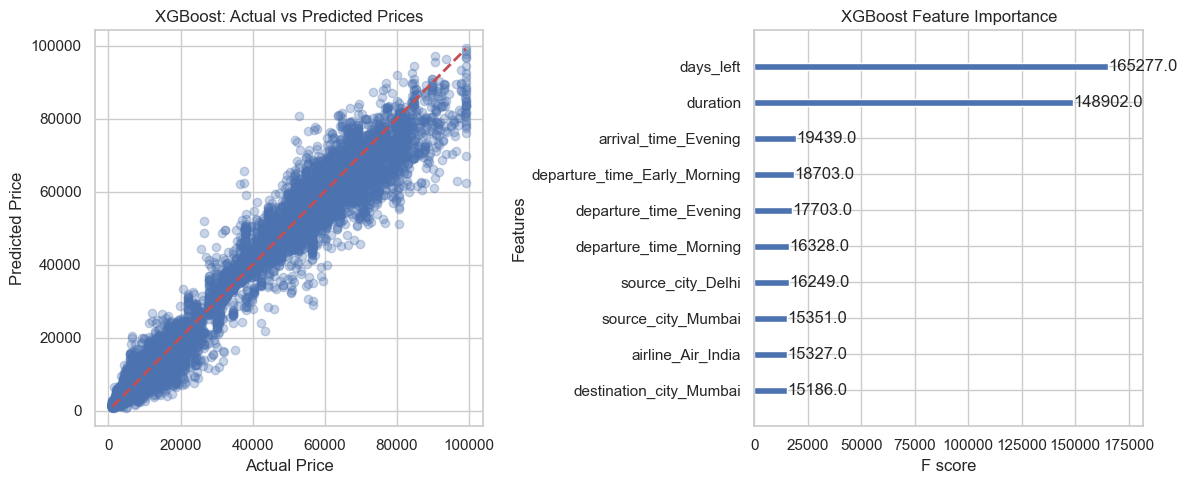

In [13]:
import xgboost as xgb
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_val_score,
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import numpy as np

# Prepare features and target
X = final_df.drop(columns=["price"])
y = final_df["price"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define hyperparameter distributions for XGBoost
xgb_params = {
    "n_estimators": randint(50, 500),
    "learning_rate": uniform(0.01, 0.3),
    "max_depth": randint(3, 15),
    "min_child_weight": randint(1, 10),
    "subsample": uniform(0.5, 1.0),
    "colsample_bytree": uniform(0.5, 1.0),
    "gamma": uniform(0, 5),
}

# Initialize base XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# Perform RandomizedSearchCV
print("Training XGBoost model...")
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=xgb_params,
    n_iter=50,
    cv=5,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

# Fit the model
random_search.fit(X_train, y_train)

# Print best parameters
print("\nBest Parameters:", random_search.best_params_)

# Get best model
best_xgb_model = random_search.best_estimator_

# Cross-validation score
cv_scores = cross_val_score(
    best_xgb_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
)

print("\nCross-validation Results:")
print(f"MSE: {-cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Set Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Create figure with two subplots
plt.figure(figsize=(12, 5))

# Actual vs Predicted Plot
plt.subplot(121)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("XGBoost: Actual vs Predicted Prices")

# Feature Importance Plot
plt.subplot(122)
xgb.plot_importance(best_xgb_model, ax=plt.gca(), max_num_features=10)
plt.title("XGBoost Feature Importance")

plt.tight_layout()
plt.show()

In [15]:
# Step 7: Deployment Considerations
# Propose a deployment strategy for the best-performing model
# Save the best model
import joblib

best_model = random_search.best_estimator_
joblib.dump(best_model, "flight_price_model.pkl")

print("Model saved as 'flight_price_model.pkl' for deployment.")

Model saved as 'flight_price_model.pkl' for deployment.


Detailed Model Performance:
Accuracy: 0.9872268645874757
Root Mean Squared Error (RMSE): 2469.09
Mean Absolute Error (MAE): 1232.15
Mean Absolute Percentage Error (MAPE): 9.53%
R-squared (R2) Score: 0.9882
Explained Variance Score: 0.9882


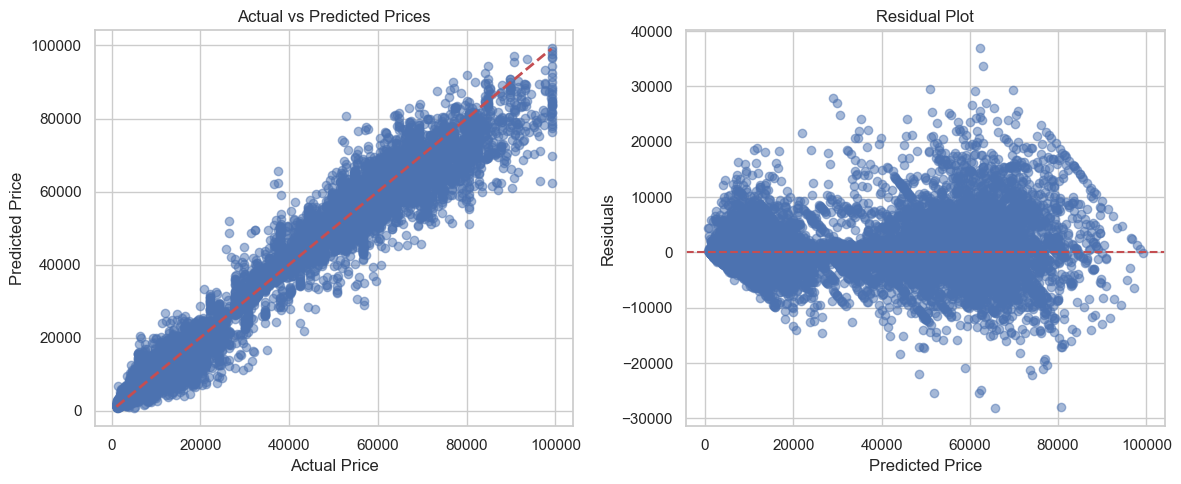


Error Analysis:
Median Absolute Error: 535.60
95th Percentile of Absolute Errors: 5043.61


In [19]:
# Step 8: Model Evaluation
# Evaluate the best model
# Load the saved model
best_model = joblib.load("flight_price_model.pkl")

# Predict on test set
y_pred = best_model.predict(X_test)

# Comprehensive Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)
acuuracies = cross_val_score(best_model, X_train, y_train, cv=5)

# Print Detailed Metrics
print("Detailed Model Performance:")
print(f"Accuracy: {acuuracies.mean()}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")
print(f"R-squared (R2) Score: {r2:.4f}")
print(f"Explained Variance Score: {explained_variance:.4f}")

# Enhanced Visualization
plt.figure(figsize=(12, 5))

# Scatter Plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")

# Residual Plot
plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color="r", linestyle="--")

plt.tight_layout()
plt.show()

# Optional: Detailed Error Analysis
print("\nError Analysis:")
print(f"Median Absolute Error: {np.median(np.abs(y_test - y_pred)):.2f}")
print(
    f"95th Percentile of Absolute Errors: {np.percentile(np.abs(y_test - y_pred), 95):.2f}"
)